In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk import bigrams
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

C:\Users\herik\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
C:\Users\herik\anaconda3\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


## Ambiente

In [2]:
seed_ = 194
np.random.seed(seed_)

## Carregando e tratando base de dados

In [3]:
df = pd.read_csv('data/df_sem_duplicatas.csv')

In [4]:
df.head()

,descricao,categoria
0,caneta bic cristal,Papelaria
1,caneta bps pilot,Papelaria
2,caneta marcador permanente acrilex ponta dupla,Papelaria
3,caneta retocar madeira branco corcel,Papelaria
4,caneta retroprojetor manter fazer castelo pont...,Papelaria


In [5]:
# Carregando LabelEncoder model
pkl_file = open('models/label_encoder.pkl', 'rb')
le = pickle.load(pkl_file) 
pkl_file.close()

In [6]:
le.fit(df['categoria'])
df['categoria'] = le.transform(df['categoria'])

In [7]:
# Salvando LabelEncoder model

#output = open('models/label_encoder.pkl', 'wb')
#pickle.dump(le, output)
#output.close()

In [8]:
# Capturando targets gerados pelo LabelEncoder
target_names = le.classes_

In [9]:
df.head()

,descricao,categoria
0,caneta bic cristal,3
1,caneta bps pilot,3
2,caneta marcador permanente acrilex ponta dupla,3
3,caneta retocar madeira branco corcel,3
4,caneta retroprojetor manter fazer castelo pont...,3


## Gerando bigrams

In [10]:
def generate_bigrams(text):
    tokens = word_tokenize(text.lower())  # Tokenize and convert to lowercase
    bigram_list = list(bigrams(tokens))   # Generate bigrams
    return [' '.join(bigram) for bigram in bigram_list]

In [11]:
# Aplica função de bigrama por linha
df['descricao_bigrams'] = df['descricao'].apply(lambda x: ' '.join(generate_bigrams(x)))

In [12]:
df.head()

,descricao,categoria,descricao_bigrams
0,caneta bic cristal,3,caneta bic bic cristal
1,caneta bps pilot,3,caneta bps bps pilot
2,caneta marcador permanente acrilex ponta dupla,3,caneta marcador marcador permanente permanente...
3,caneta retocar madeira branco corcel,3,caneta retocar retocar madeira madeira branco ...
4,caneta retroprojetor manter fazer castelo pont...,3,caneta retroprojetor retroprojetor manter mant...


## Separando em treino/teste e vetorizando

In [13]:
# Separa em treino e teste
X = df['descricao_bigrams']
y = df['categoria']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = seed_)

In [14]:
# Realiza contagem de token
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Modelagem Naive Bayes

In [15]:
def report_modelo(modelo, y, pred):
    print("Acurácia: %f" % accuracy_score(y_true = y, y_pred = pred))
    
    # Plotando a matriz de confusão
    cm = confusion_matrix(y, pred)
    cm = pd.DataFrame(cm, index = target_names, columns = target_names)

    plt.figure(figsize = (8, 8))
    sns.heatmap(cm, cmap = "Blues", linecolor = 'black', linewidths = 1, annot = True, \
                fmt = '', xticklabels = target_names, yticklabels = target_names)
    plt.show()
    
    # Imprimindo métricas
    print(classification_report(y_true = y, y_pred = pred, target_names= target_names))

In [16]:
def treinaClassificacao_GridSearchCV(modelo, params_, x_treino, y_treino, x_teste, y_teste,\
                        n_jobs = -1, cv = 5, refit = True, scoring = None, salvar_resultados = False,\
                       report_treino = False, retorna_modelo = False):
    
    # Realizando treinamento baseado no grid informado
    grid = GridSearchCV(modelo, params_, n_jobs = n_jobs, cv = cv, refit = refit, scoring = scoring)
    
    grid.fit(x_treino, y_treino)
    pred = grid.predict(x_teste)
    modelo_ = grid.best_estimator_

    print(grid.best_params_)
    
    # Realizando previsões
    y_test_pred = modelo_.predict(x_teste)
    
    # Gerando report do modelo
    report_modelo(modelo_, y_teste, y_test_pred) 
    
    # Salvando resultados em dataframe caso solicitado
    if salvar_resultados:
        resultados_df = pd.DataFrame(grid.cv_results_)
        
        if retorna_modelo:
            return resultados_df, modelo_
        else:
            resultados_df
        
    if retorna_modelo:
        return modelo_

## Molelo Base

In [17]:
# Instancia modelo base
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vec, y_train)

MultinomialNB()

Acurácia: 0.892537


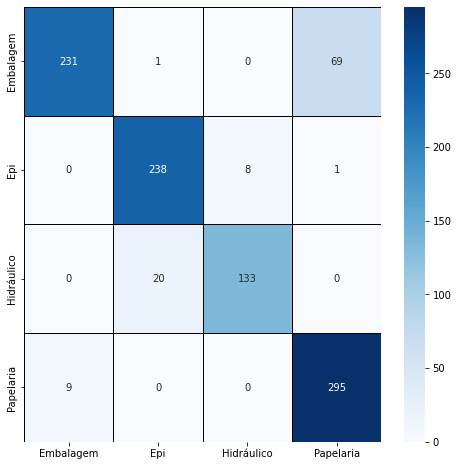

              precision    recall  f1-score   support

   Embalagem       0.96      0.77      0.85       301
         Epi       0.92      0.96      0.94       247
  Hidráulico       0.94      0.87      0.90       153
   Papelaria       0.81      0.97      0.88       304

    accuracy                           0.89      1005
   macro avg       0.91      0.89      0.90      1005
weighted avg       0.90      0.89      0.89      1005



In [18]:
# Realiza previsões e imprime report
y_pred = nb_classifier.predict(X_test_vec)
report_modelo(nb_classifier, y_test, y_pred) 

## Tuning Naive Bayes

{'alpha': 0.005}
Acurácia: 0.910448


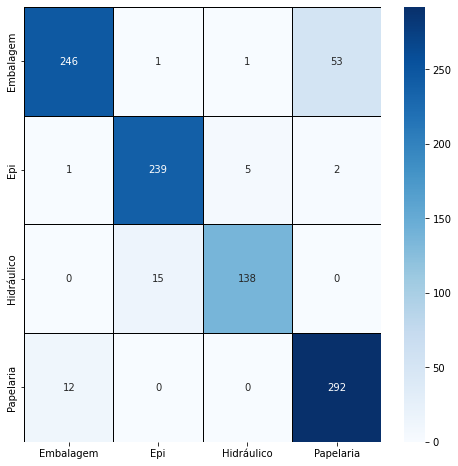

              precision    recall  f1-score   support

   Embalagem       0.95      0.82      0.88       301
         Epi       0.94      0.97      0.95       247
  Hidráulico       0.96      0.90      0.93       153
   Papelaria       0.84      0.96      0.90       304

    accuracy                           0.91      1005
   macro avg       0.92      0.91      0.91      1005
weighted avg       0.92      0.91      0.91      1005

CPU times: total: 1.73 s
Wall time: 6.98 s


In [19]:
%%time

params = {
    'alpha': [i * 0.001 for i in range(1000)]
}

# Tuning Naibe Nayes
modelo_nb = MultinomialNB()

modelo_nb = treinaClassificacao_GridSearchCV(modelo_nb, params, X_train_vec, y_train,\
                                              X_test_vec, y_test)

In [20]:
# Salvando modelo como pickle
with open('models/naive_bayes.pkl', 'wb') as model_file:
    pickle.dump(nb_classifier, model_file)